In [2]:
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.5f}'.format)

In [4]:
# 셀에서 값을 모두 출력
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import Image

In [5]:
def pd_print(x):
    pd.set_option('display.max_rows', None)
    display(x)
    pd.set_option('display.max_rows', 20)
    
def np_print(x):
    np.set_printoptions(threshold=np.inf)
    display(x)
    np.set_printoptions(threshold=10)

In [6]:
# 한글폰트적용
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)
%config InlineBackend.figure_format = 'retina'

In [7]:
os.chdir('D:/Dropbox/DataScience/Projects/고객이탈분석')

In [ ]:
os.chdir('C:/Users/wxc03/Dropbox/DataScience/Projects/고객이탈분석')

# 데이터 로드 및 탐색

In [8]:
data = pd.read_csv('telco_customer.csv')
data = data[['Churn']+data.columns.drop('Churn').tolist()]

In [138]:
print(data.head())

  Churn  customerID  gender  SeniorCitizen Partner Dependents  tenure  \
0    No  7590-VHVEG  Female              0     Yes         No       1   
1    No  5575-GNVDE    Male              0      No         No      34   
2   Yes  3668-QPYBK    Male              0      No         No       2   
3    No  7795-CFOCW    Male              0      No         No      45   
4   Yes  9237-HQITU  Female              0      No         No       2   

  PhoneService     MultipleLines InternetService OnlineSecurity OnlineBackup  \
0           No  No phone service             DSL             No          Yes   
1          Yes                No             DSL            Yes           No   
2          Yes                No             DSL            Yes          Yes   
3           No  No phone service             DSL            Yes           No   
4          Yes                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0 

In [10]:
data.shape

(7043, 21)

## 데이터 타입, 결측치, Unique values 확인

In [139]:
pd.DataFrame({'Columns':data.columns,
             'Data type':data.dtypes.values,
             'Missing_cnt':data.isna().sum().values,
             'Unique_cnt':data.nunique().values})

,Columns,Data type,Missing_cnt,Unique_cnt
0,Churn,object,0,2
1,customerID,object,0,7043
2,gender,object,0,2
3,SeniorCitizen,int64,0,2
4,Partner,object,0,2
5,Dependents,object,0,2
6,tenure,int64,0,73
7,PhoneService,object,0,2
8,MultipleLines,object,0,3
9,InternetService,object,0,3


**TotalCharges 변수가 왜 문자열(Object)로 나타나는 지 원인 파악하기**
- 일부 값이 공백으로 입력되어 있으며 이를 결측치 처리하였음
- 결측값(11건)은 모두 제거 하였음

In [140]:
print(np.sort(data['TotalCharges'].unique()))

[' ' '100.2' '100.25' ... '999.45' '999.8' '999.9']


In [161]:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

In [162]:
data = data[data['TotalCharges'].notna()].reset_index(drop=True)

## 데이터 탐색 및 전처리

### 1) 종속변수 분포 확인

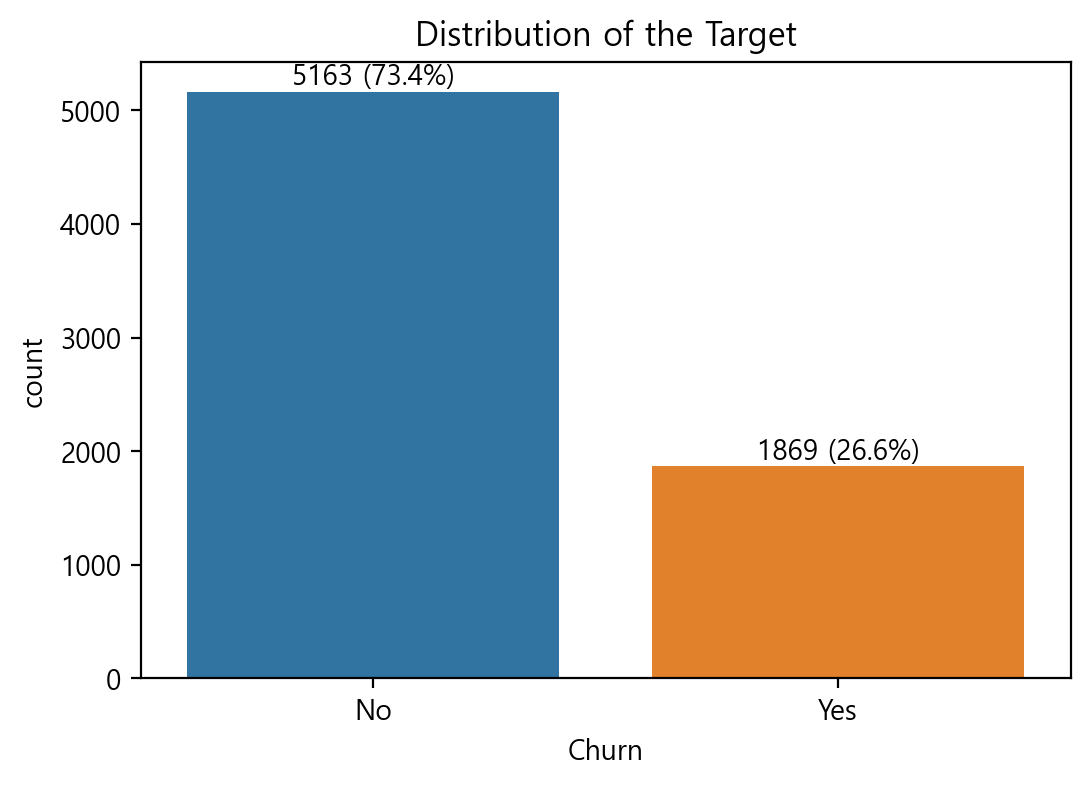

In [143]:
_ = plt.subplots(figsize=(6,4))

ax = sns.countplot(x=data['Churn'])

abs_values = data['Churn'].value_counts()
rel_values = data['Churn'].value_counts(normalize=True).values*100
labels = [f'{p[0]} ({p[1]:.1f}%)' for p in zip(abs_values, rel_values)]
_ = ax.bar_label(container=ax.containers[0], labels=labels)

_ = plt.title('Distribution of the Target')

### 2) 범주형 변수 처리

- Binary 변수는 0, 1 값으로 처리
- Categorical 변수는 One-hot encoding
    - 인터넷 서비스와 관련된 여러 변수들(InternetService, OnlieSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies)에서 Internet Service를 사용하지 않는 유저의 응답이 계속 나타나기 때문에 One-hot encoding을 수행하기 전에 Internet Service를 사용하는지 여부를 나타내는 더미 변수를 먼저 생성한 후  Internet Service를 사용하지 않는 유저의 응답은 drop 하여 One-hot encoding 수행하였음

In [163]:
data_pre = data.copy()

In [164]:
# Binary variables
data_pre['gender'] = np.where(data_pre['gender']=='Female', 0, 1)
data_pre['Partner'] = np.where(data_pre['Partner']=='No', 0, 1)
data_pre['Dependents'] = np.where(data_pre['Dependents']=='No', 0, 1)
data_pre['PhoneService'] = np.where(data_pre['PhoneService']=='No', 0, 1)
data_pre['PaperlessBilling'] = np.where(data_pre['PaperlessBilling']=='No', 0, 1)
data_pre['Churn'] = np.where(data_pre['Churn']=='No', 0, 1)

In [188]:
# Exploring the categorical variables
print(data_pre['MultipleLines'].value_counts())
print(data_pre['InternetService'].value_counts())
print(data_pre['OnlineSecurity'].value_counts())
print(data_pre['OnlineBackup'].value_counts())
print(data_pre['DeviceProtection'].value_counts())
print(data_pre['TechSupport'].value_counts())
print(data_pre['StreamingTV'].value_counts())
print(data_pre['StreamingMovies'].value_counts())
print(data_pre['Contract'].value_counts())
print(data_pre['PaymentMethod'].value_counts())

No                  3385
Yes                 2967
No phone service     680
Name: MultipleLines, dtype: int64
Fiber optic    3096
DSL            2416
No             1520
Name: InternetService, dtype: int64
No                     3497
Yes                    2015
No internet service    1520
Name: OnlineSecurity, dtype: int64
No                     3087
Yes                    2425
No internet service    1520
Name: OnlineBackup, dtype: int64
No                     3094
Yes                    2418
No internet service    1520
Name: DeviceProtection, dtype: int64
No                     3472
Yes                    2040
No internet service    1520
Name: TechSupport, dtype: int64
No                     2809
Yes                    2703
No internet service    1520
Name: StreamingTV, dtype: int64
No                     2781
Yes                    2731
No internet service    1520
Name: StreamingMovies, dtype: int64
Month-to-month    3875
Two year          1685
One year          1472
Name: Contract, d

In [165]:
data_pre['MultipleLines'] = data_pre['MultipleLines'].astype('category').cat.reorder_categories(['No phone service', 'Yes', 'No'])
data_pre['InternetService'] = data_pre['InternetService'].astype('category').cat.reorder_categories(['No', 'DSL', 'Fiber optic'])
data_pre['OnlineSecurity'] = data_pre['OnlineSecurity'].astype('category').cat.reorder_categories(['No internet service', 'Yes', 'No'])
data_pre['OnlineBackup'] = data_pre['OnlineBackup'].astype('category').cat.reorder_categories(['No internet service', 'Yes', 'No'])
data_pre['DeviceProtection'] = data_pre['DeviceProtection'].astype('category').cat.reorder_categories(['No internet service', 'Yes', 'No'])
data_pre['TechSupport'] = data_pre['TechSupport'].astype('category').cat.reorder_categories(['No internet service', 'Yes', 'No'])
data_pre['StreamingTV'] = data_pre['StreamingTV'].astype('category').cat.reorder_categories(['No internet service', 'Yes', 'No'])
data_pre['StreamingMovies'] = data_pre['StreamingMovies'].astype('category').cat.reorder_categories(['No internet service', 'Yes', 'No'])

In [166]:
data_pre['InternetService_No'] = np.where(data_pre['InternetService'] == 'No', 1, 0)
data_pre = pd.get_dummies(data=data_pre, columns=['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod'], drop_first=True)

### 2) 연속형 변수 처리

In [167]:
num_uniq = data_pre.nunique()
num_cols = num_uniq[num_uniq > 2].keys().tolist()
num_cols = [col for col in num_cols if col not in ['customerID']]

데이터를 정규화한 후 박스플롯을 통해 분포 확인

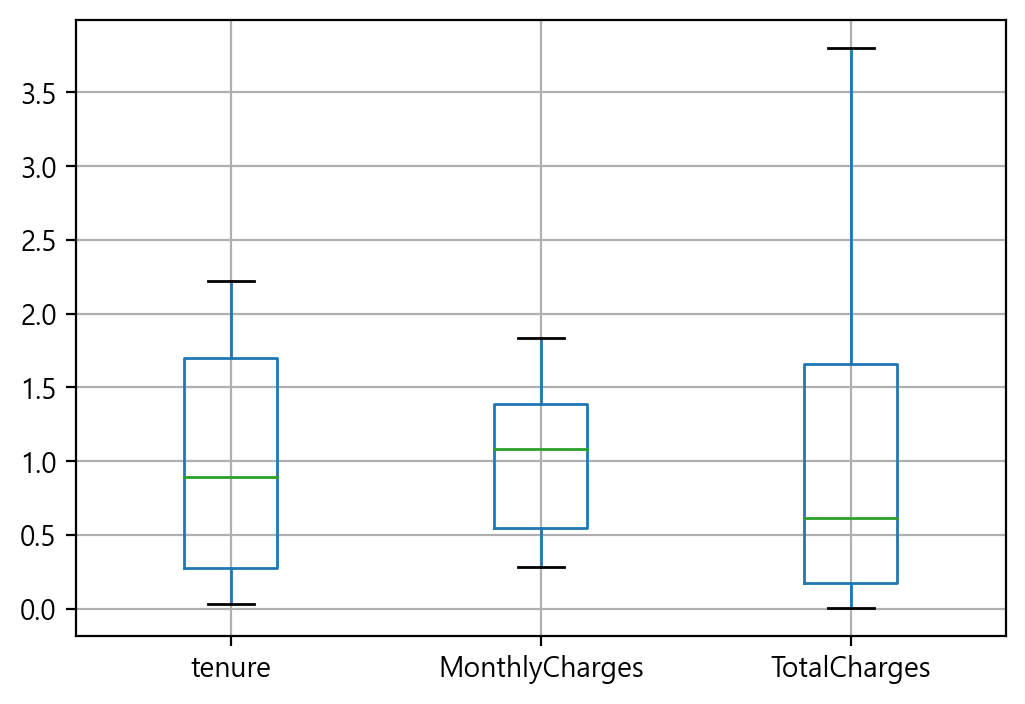

In [192]:
normalized = data_pre / data_pre.mean()
_ = plt.subplots(figsize=(6,4))
_ = normalized[num_cols].boxplot()

데이터의 분포와 연속형 데이터 간의 관계를 알아보았음. 분포의 형태를 통해서 해당 데이터셋이 서로 다른 특성을 가진 집단들로 구성되어 있음을 짐작할 수 있음.

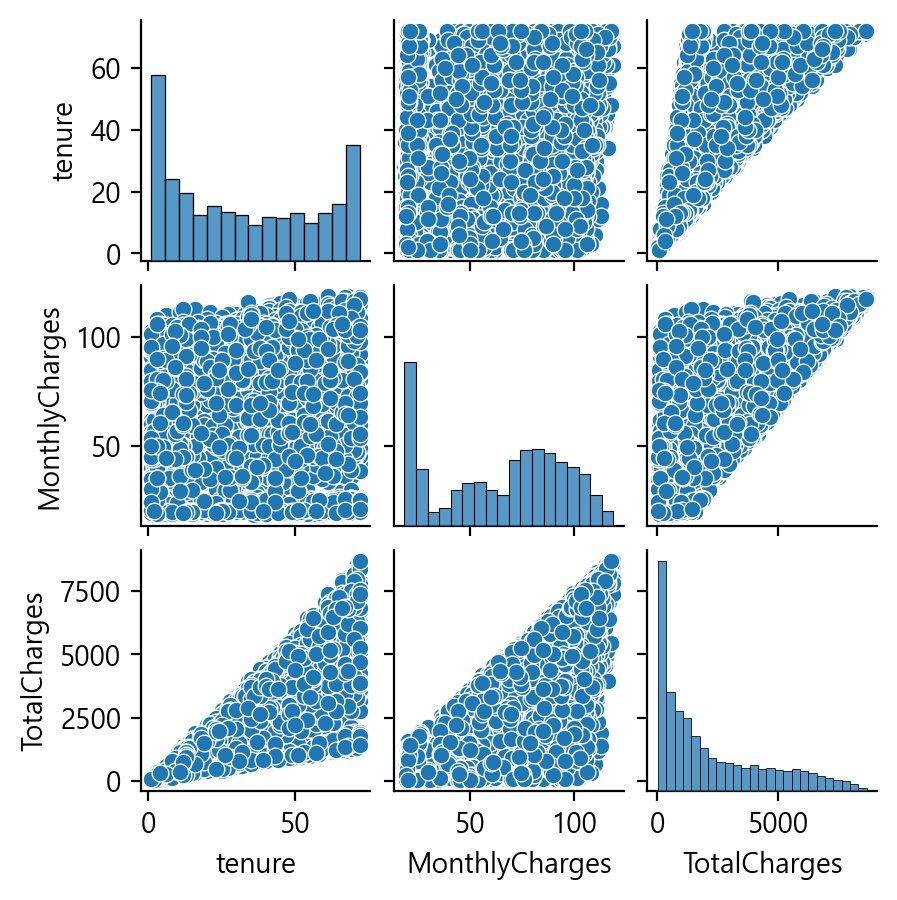

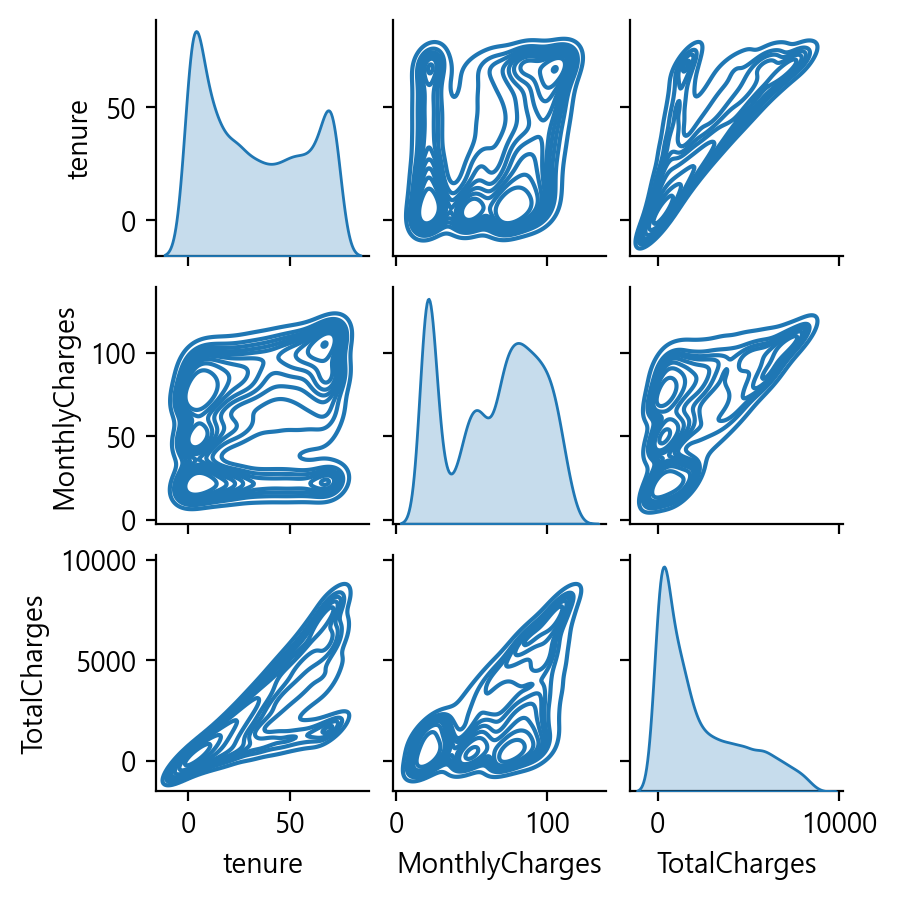

In [151]:
_ = sns.pairplot(data_pre[num_cols], kind='scatter', height=1.5)
_ = sns.pairplot(data_pre[num_cols], kind='kde', height=1.5)

# 클러스터링

서비스의 이용기간과 현재 월 요금을 기준으로 고객군의 구분을 통해 이용기간이 길면서 고액의 요금제를 사용하는 클러스터를 핵심 고객군으로 분류하여 본 프로젝트의 분석 대상 데이터 세트로 정의하고자 함.

## 1) 표준화

In [170]:
X = data_pre.drop(['customerID', 'Churn'], axis=1)
mask = X.nunique()
num_cols = mask[mask>2].keys().tolist()
cat_cols = [col for col in X.columns if col not in num_cols]

scaler = StandardScaler()
X_scale = scaler.fit_transform(X[num_cols])

X_scale_df = pd.DataFrame(np.concatenate((X_scale, X[cat_cols]), axis=1), columns=num_cols + cat_cols)
X_scale_cl = X_scale_df[['tenure', 'MonthlyCharges']]

## 2) 클러스터링

### 2.1) K 평균 클러스터링

In [116]:
from sklearn.cluster import KMeans
km4 = KMeans(n_clusters=4, random_state=802)
km4.fit(X_scale_cl)

KMeans(n_clusters=4, random_state=802)

In [117]:
condlst = [km4.labels_ == 0, km4.labels_ == 1, km4.labels_ == 2]
choicelst = ['G3', 'G1', 'G4']
km4_labels = np.select(condlist=condlst, choicelist=choicelst, default='G2')

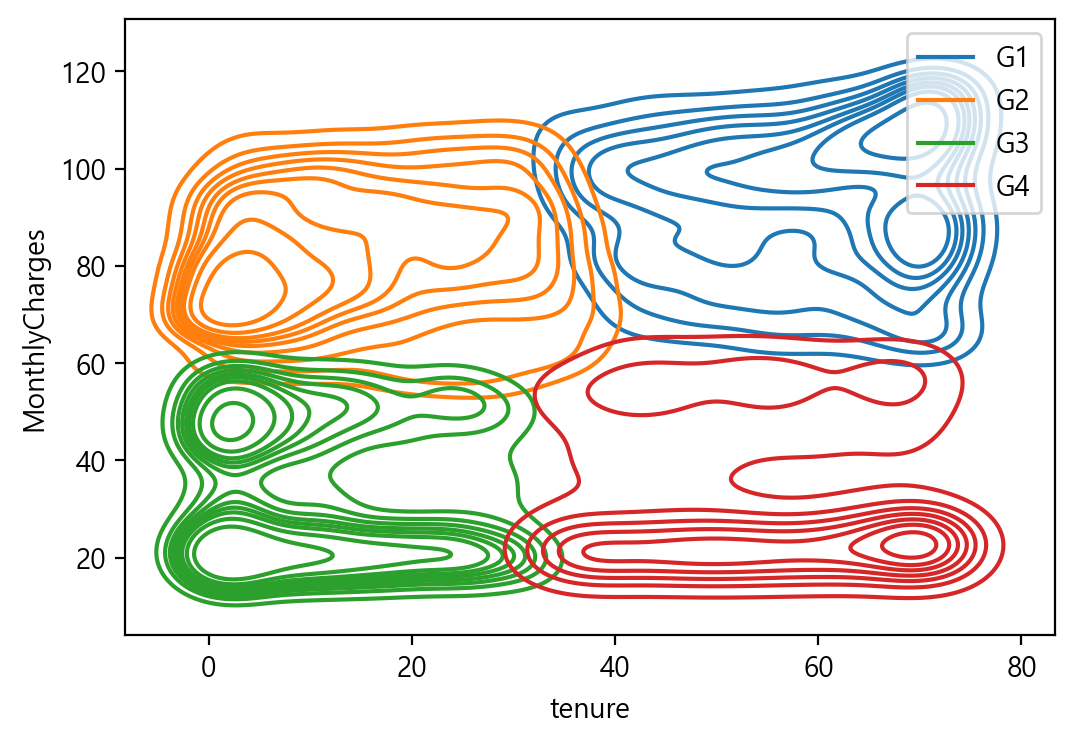

In [121]:
fig, ax = plt.subplots(figsize=(6,4))

_ = sns.kdeplot(x=data_pre['tenure'], y=data_pre['MonthlyCharges'], hue=km4_labels, hue_order=['G1', 'G2', 'G3', 'G4'])

### 2.2) Agglomerative Clustering

- linkage: ward

In [171]:
from sklearn.cluster import AgglomerativeClustering

ward4 = AgglomerativeClustering(n_clusters=4, linkage='ward')
ward4.fit(X_scale_cl)

AgglomerativeClustering(n_clusters=4)

In [172]:
condlst = [ward4.labels_ == 0, ward4.labels_ == 1, ward4.labels_ == 2]
choicelst = ['G1', 'G3', 'G2']
ward4_labels = np.select(condlist=condlst, choicelist=choicelst, default='G4')

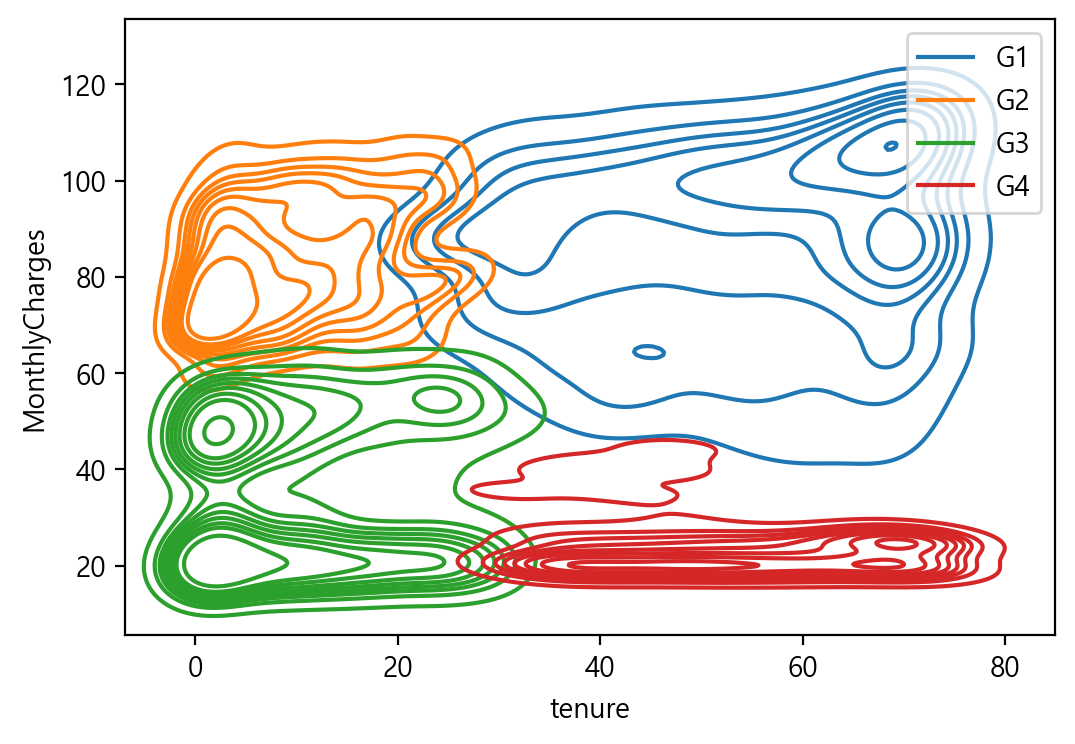

In [173]:
fig, ax = plt.subplots(figsize=(6,4))

_ = sns.kdeplot(x=data_pre['tenure'], y=data_pre['MonthlyCharges'], hue=ward4_labels, hue_order=['G1', 'G2', 'G3', 'G4'])

### 2.3) Gaussian Mixture Model

In [122]:
from sklearn.mixture import GaussianMixture

gmm4 = GaussianMixture(n_components=4, random_state=802)
gmm4.fit(X_scale_cl)

GaussianMixture(n_components=4, random_state=802)

In [123]:
condlst = [gmm4.predict(X_scale_cl) == 0, gmm4.predict(X_scale_cl) == 1, gmm4.predict(X_scale_cl) == 2]
choicelst = ['G3', 'G1', 'G4']
gmm4_labels = np.select(condlist=condlst, choicelist=choicelst, default='G2')

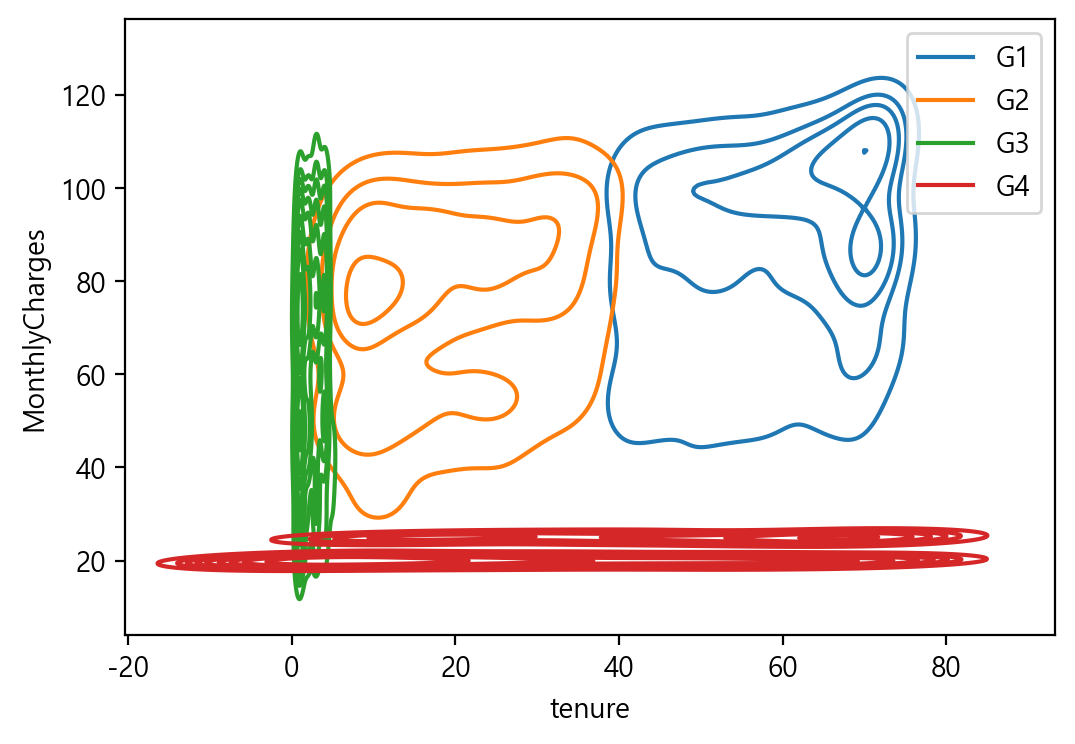

In [124]:
fig, ax = plt.subplots(figsize=(6,4))

_ = sns.kdeplot(x=data_pre['tenure'], y=data_pre['MonthlyCharges'], hue=gmm4_labels, hue_order=['G1', 'G2', 'G3', 'G4'])

## 3) 클러스터 특성 분석

이용기간이 오래되었고 평균적인 월 요금이 높은 충성고객층에서의 이탈을 예측하고자 하였음. 여러 클러스터 분석의 결과를 비교하였을 때 충성고객의 특성을 가장 잘 나타내는 군집을 보여주는 KM 클러스터링 결과를 활용하여 분석을 수행하였음. (비교 과정은 생략)

클러스터간 비교를 통해 타겟 클러스터의 특징을 분석하였음.

In [174]:
data_pre['cluster'] = ward4_labels
data_pre = data_pre[['Churn'] + num_cols + cat_cols + ['cluster']]

In [175]:
data_pre.groupby('cluster').mean().T

cluster,G1,G2,G3,G4
Churn,0.176,0.575,0.241,0.026
tenure,53.260,9.560,10.906,52.966
MonthlyCharges,86.123,82.118,34.340,24.048
TotalCharges,4616.211,805.753,384.492,1253.954
gender,0.505,0.485,0.522,0.504
SeniorCitizen,0.209,0.233,0.073,0.061
Partner,0.642,0.313,0.317,0.633
Dependents,0.323,0.167,0.299,0.472
PhoneService,0.922,0.999,0.810,0.860
PaperlessBilling,0.680,0.758,0.432,0.323


In [176]:
with open('data_pre.pickle', 'wb') as file:
    pickle.dump(data_pre, file)

In [8]:
with open('data_pre.pickle', 'rb') as file:
    data_pre = pickle.load(file)

타겟 클러스터(G1)의 특징을 다른 클러스터와 비교하여 살펴 보건데 타겟 클러스터에 포함된 사용자는 모두 인터넷 서비스를 사용하고 있어 이에 따라 인터넷 서비스의 이용 여부를 나타내는 InternetService_No 변수를 제거하고 인터넷 서비스와 관련된 변수들을 재처리 하였음.
또한 서로 공선성을 일으키는 더미 변수들(MultipleLine)은 하나의 변수만 남기고 제거하였음.

In [9]:
G1_df = data_pre[data_pre['cluster'] == 'G1'].reset_index(drop=True)

G1_df['MultipleLines'] = np.where(G1_df['MultipleLines_Yes'], 1, 0)
G1_df['OnlineSecurity'] = np.where(G1_df['OnlineSecurity_Yes'], 1, 0)
G1_df['OnlineBackup'] = np.where(G1_df['OnlineBackup_Yes'], 1, 0)
G1_df['DeviceProtection'] = np.where(G1_df['DeviceProtection_Yes'], 1, 0)
G1_df['TechSupport'] = np.where(G1_df['TechSupport_Yes'], 1, 0)
G1_df['StreamingTV'] = np.where(G1_df['StreamingTV_Yes'], 1, 0)
G1_df['StreamingMovies'] = np.where(G1_df['StreamingMovies_Yes'], 1, 0)

G1_df = G1_df.drop(['cluster', 'InternetService_No', 'MultipleLines_Yes', 'MultipleLines_No', 'InternetService_DSL', 'OnlineSecurity_Yes', 'OnlineSecurity_No', 'OnlineBackup_Yes', 'OnlineBackup_No', 'DeviceProtection_Yes', 'DeviceProtection_No', 'TechSupport_Yes', 'TechSupport_No', 'StreamingTV_Yes', 'StreamingTV_No', 'StreamingMovies_Yes', 'StreamingMovies_No'],
                   axis=1)

타겟 클러스터 사용자에 대하여 1개월 이내에 서비스 이탈 여부에 따라 고객층의 특성을 평균값을 이용하여 나타내었음.

In [10]:
tmp = G1_df.copy()
tmp['Churn'] = np.where(tmp['Churn']==1, 'Yes', 'No')
tmp.groupby('Churn').mean().T

Churn,No,Yes
tenure,54.90578,45.57600
MonthlyCharges,85.06490,91.06710
TotalCharges,4705.91857,4197.27940
gender,0.50278,0.51600
SeniorCitizen,0.18330,0.32800
Partner,0.65739,0.56800
Dependents,0.34518,0.22000
PhoneService,0.91520,0.95400
PaperlessBilling,0.65310,0.80400
InternetService_Fiber optic,0.55803,0.85800


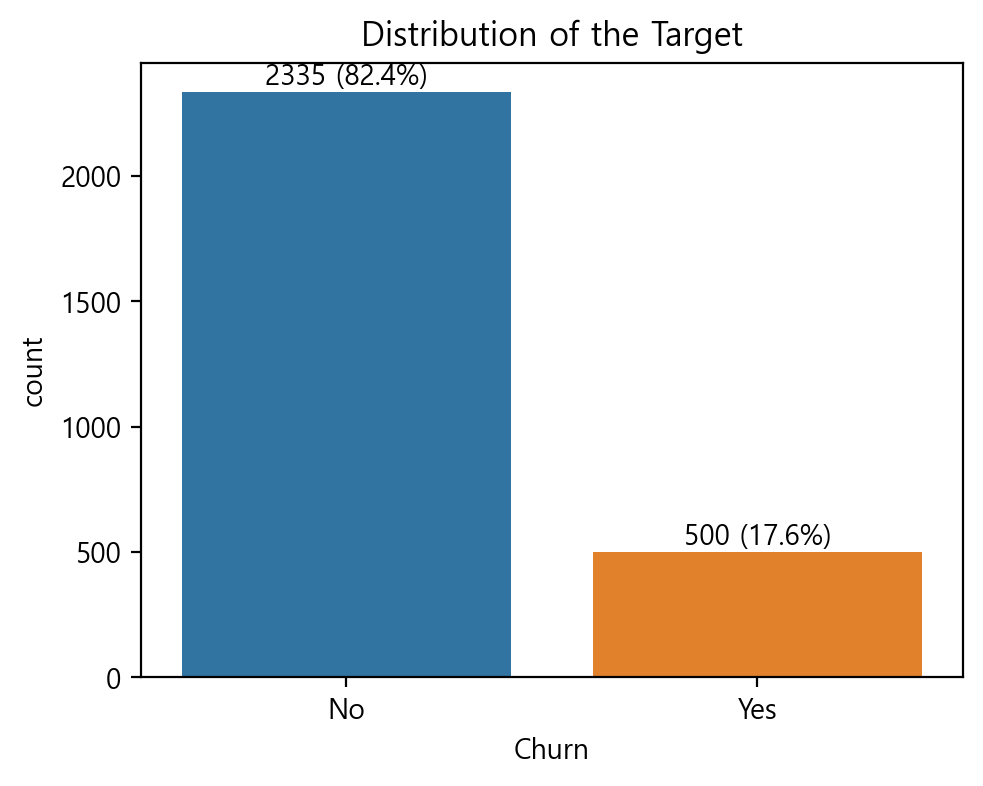

In [15]:
fig, ax = plt.subplots(figsize=(5,4))
_ = sns.countplot(x=tmp['Churn'])

abs_values = tmp['Churn'].value_counts()
rel_values = tmp['Churn'].value_counts(normalize=True).values*100
labels = [f'{p[0]} ({p[1]:.1f}%)' for p in zip(abs_values, rel_values)]
_ = ax.bar_label(container=ax.containers[0], labels=labels)

_ = plt.title('Distribution of the Target')
_ = plt.tight_layout()

In [181]:
with open('G1_df.pickle', 'wb') as file:
    pickle.dump(G1_df, file)

In [16]:
with open('G1_df.pickle', 'rb') as file:
    G1_df = pickle.load(file)

# 예측 모델링

## 1) 데이터 분할

In [17]:
X = G1_df.drop(['Churn'], axis=1)
y = G1_df['Churn']

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=802, stratify=y)

## 2) 표준화

In [18]:
mask = train_X.nunique()
num_cols = mask[mask>2].keys().tolist()
cat_cols = [col for col in X.columns if col not in num_cols]

scaler2 = StandardScaler()
train_X_scale = scaler2.fit_transform(train_X[num_cols])
test_X_scale = scaler2.transform(test_X[num_cols])

train_X_scale = pd.DataFrame(np.concatenate((train_X_scale, train_X[cat_cols]), axis=1), columns=num_cols+cat_cols)
test_X_scale = pd.DataFrame(np.concatenate((test_X_scale, test_X[cat_cols]), axis=1), columns=num_cols+cat_cols)

## 3) Feature selection: RFE

Random forest 알고리즘을 활용하여 RFE(Reculsive Feature Elimination)을 수행.
모델링을 통해 변수 중요도를 산출한 다음, 가장 중요도가 낮은 변수를 2개씩 제거해 나가며 반복적으로 모델링을 수행해 모델의 예측 성능에 유효한 변수만 선택

In [19]:
from sklearn.ensemble import RandomForestClassifier

# Create dictionary to store AUC score and dropped features
auc_score = dict()
dropped_feature = dict()

# Loop for feature selection
num_features = train_X.shape[1]
selected_features = X.columns

for i in range(num_features):
    # Train the random forest on the selected features
    rfe_rf = RandomForestClassifier(n_estimators=200, random_state=802, max_depth=5)
    rfe_rf.fit(train_X_scale.loc[:, selected_features], train_y)
    
    # Predict on the test set and calculate AUC score
    pred_selected = rfe_rf.predict_proba(test_X_scale.loc[:, selected_features])[:, 1]
    auc_selected = roc_auc_score(test_y, pred_selected)
    auc_score[i] = auc_selected
    
    # Get feature importance from the model
    feature_importance = pd.DataFrame(dict(col = selected_features,
                                       importance = rfe_rf.feature_importances_))
    
    # Remove the two least important features
    dropped_feature[i+1] = feature_importance.sort_values('importance').iloc[:2, 0].tolist()
    selected_features = [ind for ind in selected_features if ind not in dropped_feature[i+1]]
    
    # Stop if the AUC score is 0.01 lower than the highest AUC score
    if max(auc_score.values()) - auc_selected > 0.02:
        break

RandomForestClassifier(max_depth=5, n_estimators=200, random_state=802)

RandomForestClassifier(max_depth=5, n_estimators=200, random_state=802)

RandomForestClassifier(max_depth=5, n_estimators=200, random_state=802)

RandomForestClassifier(max_depth=5, n_estimators=200, random_state=802)

RandomForestClassifier(max_depth=5, n_estimators=200, random_state=802)

RandomForestClassifier(max_depth=5, n_estimators=200, random_state=802)

RandomForestClassifier(max_depth=5, n_estimators=200, random_state=802)

RandomForestClassifier(max_depth=5, n_estimators=200, random_state=802)

RandomForestClassifier(max_depth=5, n_estimators=200, random_state=802)

In [20]:
auc_lst = list(auc_score.values())

In [21]:
dropped_feature_lst = list(dropped_feature.values())
dropped_feature_lst.insert(0, None)
dropped_feature_lst = dropped_feature_lst[:-1]

In [182]:
RFE_res = pd.DataFrame(dict(index=range(len(auc_lst)),
                 dropped_feature = dropped_feature_lst,
                 auc = auc_lst))
RFE_res

,index,dropped_feature,auc
0,0,None,0.78456
1,1,"[PhoneService, PaymentMethod_Mailed check]",0.78806
2,2,"[PaymentMethod_Credit card (automatic), Partner]",0.78678
3,3,"[Dependents, gender]",0.78483
4,4,"[DeviceProtection, StreamingTV]",0.78674
5,5,"[StreamingMovies, OnlineBackup]",0.78333
6,6,"[MultipleLines, PaperlessBilling]",0.77951
7,7,"[SeniorCitizen, OnlineSecurity]",0.77105
8,8,"[Contract_One year, PaymentMethod_Electronic c...",0.75204


In [22]:
final_dropped_features = [feature for sub_lst in dropped_feature_lst[1:5] for feature in sub_lst]
final_selected = [feature for feature in X.columns if feature not in final_dropped_features]

In [23]:
train_X_final_stdO = train_X_scale[final_selected]
test_X_final_stdO = test_X_scale[final_selected]

train_X_final_stdX = train_X[final_selected]
test_X_final_stdX = test_X[final_selected]

## 4) 예측 모델링

In [680]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, average_precision_score, recall_score, precision_score, f1_score

def print_score(actual, pred, prob):
    print(confusion_matrix(actual, pred))
    print(f"\nAccuracy Score: {round(accuracy_score(actual, pred), 5)*100}%")
    print(f"AUC Score: {round(roc_auc_score(actual, prob), 5)}")
    print(f'Precision-recall Score: {round(average_precision_score(actual, prob), 5)}')
    print("-----------------------------------------------")
    print(classification_report(actual, pred))
    print("-----------------------------------------------")

### 4.1) Elastic Net

In [693]:
from sklearn.linear_model import LogisticRegression

elastic = LogisticRegression(max_iter=200, penalty='elasticnet', solver='saga')
elastic_grid = {'C':np.round(np.linspace(0.01, 1, num=30), 4),
               'l1_ratio':np.linspace(0, 1, num=6)}

elastic_grid_search = GridSearchCV(elastic, elastic_grid, cv=5, scoring='roc_auc').fit(train_X_final_stdO, train_y)

In [694]:
best_penalty = elastic_grid_search.best_params_['C']
best_l1 = elastic_grid_search.best_params_['l1_ratio']

best_elastic_net = LogisticRegression(C=best_penalty, l1_ratio=best_l1)
best_elastic_net.fit(train_X_final_stdO, train_y)

LogisticRegression(C=0.7952, l1_ratio=0.4)

**Model performance**

In [698]:
pred_prob_elastic = best_elastic_net.predict_proba(test_X_final_stdO)[:,1]
pred_class_elastic = np.where(pred_prob_elastic>0.5, 1, 0)

auc_elastic = round(roc_auc_score(test_y.tolist(), pred_prob_elastic), 5)
prauc_elastic = round(average_precision_score(test_y.tolist(), pred_prob_elastic), 5)
recall_elastic = round(recall_score(test_y.tolist(), pred_class_elastic), 5)
precision_elastic = round(precision_score(test_y.tolist(), pred_class_elastic), 5)
f1_elastic = ((1+1**1)*(precision_elastic * recall_elastic)) / (1**1*precision_elastic + recall_elastic)
f2_elastic = ((1+2**2)*(precision_elastic * recall_elastic)) / (2**2*precision_elastic + recall_elastic)

print('Performance for Elastic net')
print_score(test_y.tolist(), pred_class_elastic, pred_prob_elastic)

Performance for Elastic net
[[686  15]
 [121  29]]

Accuracy Score: 84.019%
AUC Score: 0.78722
Precision-recall Score: 0.46465
-----------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       701
           1       0.66      0.19      0.30       150

    accuracy                           0.84       851
   macro avg       0.75      0.59      0.60       851
weighted avg       0.82      0.84      0.80       851

-----------------------------------------------


### 4.2) Random Forest

In [776]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=300, class_weight='balanced', warm_start=True, random_state=802, n_jobs=-1)
rf_grid = {'max_depth':[3, 5, 7]}

rf_grid_search = GridSearchCV(rf, rf_grid, cv=5, scoring='roc_auc').fit(train_X_final_stdX, train_y)

In [777]:
best_max_depth = rf_grid_search.best_params_['max_depth']

best_rf = RandomForestClassifier(n_estimators=300, class_weight='balanced', warm_start=True, random_state=802, n_jobs=-1, max_depth=best_max_depth)
best_rf.fit(train_X_final_stdX, train_y)

RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=300,
                       n_jobs=-1, random_state=802, warm_start=True)

**Model performance**

In [691]:
pred_prob_rf = best_rf.predict_proba(test_X_final_stdX)[:,1]
pred_class_rf = np.where(pred_prob_rf>0.5, 1, 0)

auc_rf = round(roc_auc_score(test_y.tolist(), pred_prob_rf), 5)
prauc_rf = round(average_precision_score(test_y.tolist(), pred_prob_rf), 5)
recall_rf = round(recall_score(test_y.tolist(), pred_class_rf), 5)
precision_rf = round(precision_score(test_y.tolist(), pred_class_rf), 5)
f1_rf = ((1+1**1)*(precision_rf * recall_rf)) / (1**1*precision_rf + recall_rf)
f2_rf = ((1+2**2)*(precision_rf * recall_rf)) / (2**2*precision_rf + recall_rf)

print('Performance for Random Forest')
print_score(test_y.reset_index(drop=True), pred_class_rf, pred_prob_rf)

Performance for Random Forest
[[466 235]
 [ 33 117]]

Accuracy Score: 68.508%
AUC Score: 0.783
Precision-recall Score: 0.4657
-----------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.66      0.78       701
           1       0.33      0.78      0.47       150

    accuracy                           0.69       851
   macro avg       0.63      0.72      0.62       851
weighted avg       0.83      0.69      0.72       851

-----------------------------------------------


### 4.3) XGBoost

In [24]:
import xgboost as xgb

neg_cnt = len(train_y[train_y==0])
pos_cnt = len(train_y[train_y==1])
pos_weight = neg_cnt/pos_cnt

xgboost = xgb.XGBClassifier(n_jobs=-1, random_state=802, early_stopping_rounds=30, scale_pos_weight=pos_weight)

xgb_grid = {'n_estimators':[5000],
           'max_depth':[3, 5],
           'learning_rate':[0.001, 0.005],
           'subsample':[0.6],
           'colsample_bytree':[0.6]}

eval_set = [(train_X_final_stdX, train_y), (test_X_final_stdX, test_y)]
xgb_grid_search = GridSearchCV(xgboost, xgb_grid, cv=5, scoring='roc_auc').fit(train_X_final_stdX, train_y, eval_set=eval_set, verbose=0)

In [25]:
xgb_best_params = xgb_grid_search.best_params_
best_xgb = xgb.XGBClassifier(n_jobs=-1, random_state=802, early_stopping_rounds=30, scale_pos_weight=pos_weight, **xgb_best_params)
best_xgb.fit(train_X_final_stdX, train_y, eval_set=eval_set, eval_metric='logloss', verbose=0)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, early_stopping_rounds=30,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=5000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=802, ...)

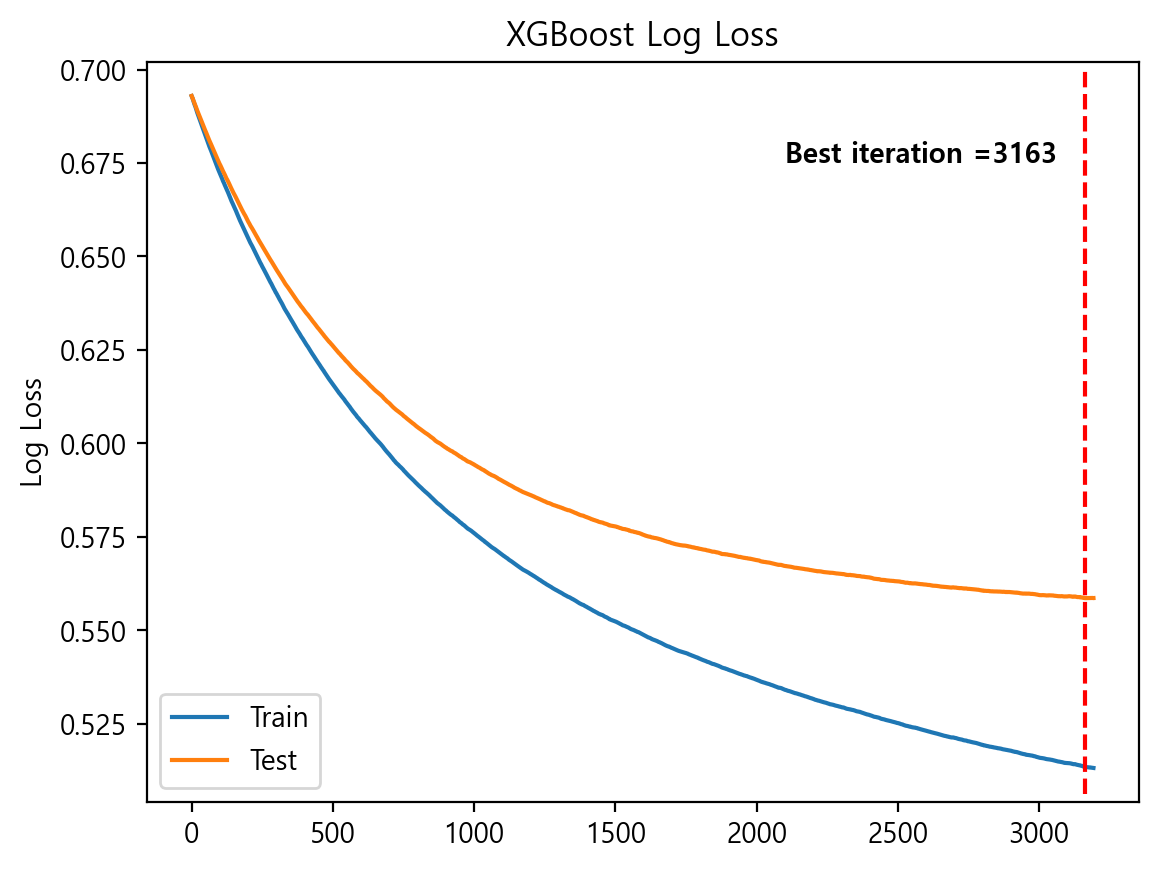

In [834]:
# Find the best iteration
results = best_xgb.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

# plot log loss
fig, ax = plt.subplots()
_ = ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
_ = ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
_ = ax.legend()
_ = plt.axvline(x=best_xgb.best_iteration, ymin=0.01, ymax=0.99, linestyle='--', color='red')
_ = plt.text(s='Best iteration ='+str(best_xgb.best_iteration), x=2100, y=0.675, fontdict=dict(weight='bold'))
_ = plt.ylabel('Log Loss')
_ = plt.title('XGBoost Log Loss')
_ = plt.show()

**Model performance**

In [745]:
pred_prob_xgb = best_xgb.predict_proba(test_X_final_stdX)[:,1]
pred_class_xgb = np.where(pred_prob_xgb>0.5, 1, 0)

auc_xgb = round(roc_auc_score(test_y.tolist(), pred_prob_xgb), 5)
prauc_xgb = round(average_precision_score(test_y.tolist(), pred_prob_xgb), 5)
recall_xgb = round(recall_score(test_y.tolist(), pred_class_xgb), 5)
precision_xgb = round(precision_score(test_y.tolist(), pred_class_xgb), 5)
f1_xgb = ((1+1**1)*(precision_xgb * recall_xgb)) / (1**1*precision_xgb + recall_xgb)
f2_xgb = ((1+2**2)*(precision_xgb * recall_xgb)) / (2**2*precision_xgb + recall_xgb)

print('Performance for XGBoost')
print_score(test_y.reset_index(drop=True), pred_class_xgb, pred_prob_xgb)

Performance for XGBoost
[[456 245]
 [ 31 119]]

Accuracy Score: 67.568%
AUC Score: 0.78724
Precision-recall Score: 0.46585
-----------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.65      0.77       701
           1       0.33      0.79      0.46       150

    accuracy                           0.68       851
   macro avg       0.63      0.72      0.62       851
weighted avg       0.83      0.68      0.71       851

-----------------------------------------------


## 5) 성능 비교

In [ ]:
pd.DataFrame(dict(Model=['Elastic net', 'Random Forest', 'XGBoost'],
                 AUROC=[auc_elastic, auc_rf, auc_xgb],
                 PR_AUC=[prauc_elastic, prauc_rf, prauc_xgb],
                 Recall=[recall_elastic, recall_rf, recall_xgb],
                 Precision=[precision_elastic, precision_rf, precision_xgb],
                 F1=[f1_elastic, f1_rf, f1_xgb],
                 F2=[f2_elastic, f2_rf, f2_xgb]))

,Model,AUROC,PR_AUC,Recall,Precision,F1,F2
0,Elastic net,0.78722,0.46465,0.19333,0.65909,0.29896,0.22515
1,Random Forest,0.78300,0.46570,0.78000,0.33239,0.46614,0.61450
2,XGBoost,0.78739,0.46633,0.79333,0.32782,0.46393,0.61786


## 6) 변수 중요도 (XGBoost)

 - XGBoost 모델을 적합할 때 계산되는 Gini 지수를 바탕으로 변수의 중요도를 파악하고 시각화 하였음.
 - 중요도가 높게 산출된 변수 5개를 활용하여 Partial Dependency Plots(PDP; 부분 의존도 플롯)을 그려 각 변수가 종속변수(Churn; 1개월 내 이탈여부)에 미치는 영향을 시각화 하였음.
     - 이때 PDP를 그리기 전에 모형에서 산출하는 Probability score를 보정(Calibration) 하여 해석을 용이하게 하였음.

In [677]:
xgb_gini_importance =pd.DataFrame(dict(variable=final_selected, importance=best_xgb.feature_importances_)).sort_values('importance', ascending=False).reset_index(drop=True)
xgb_gini_importance

,variable,importance
0,Contract_Two year,0.23783
1,InternetService_Fiber optic,0.15618
2,TechSupport,0.07086
3,Contract_One year,0.07026
4,tenure,0.06731
5,OnlineSecurity,0.06546
6,PaymentMethod_Electronic check,0.05500
7,StreamingMovies,0.05252
8,MonthlyCharges,0.04608
9,TotalCharges,0.04215


<Axes: ylabel='variable'>

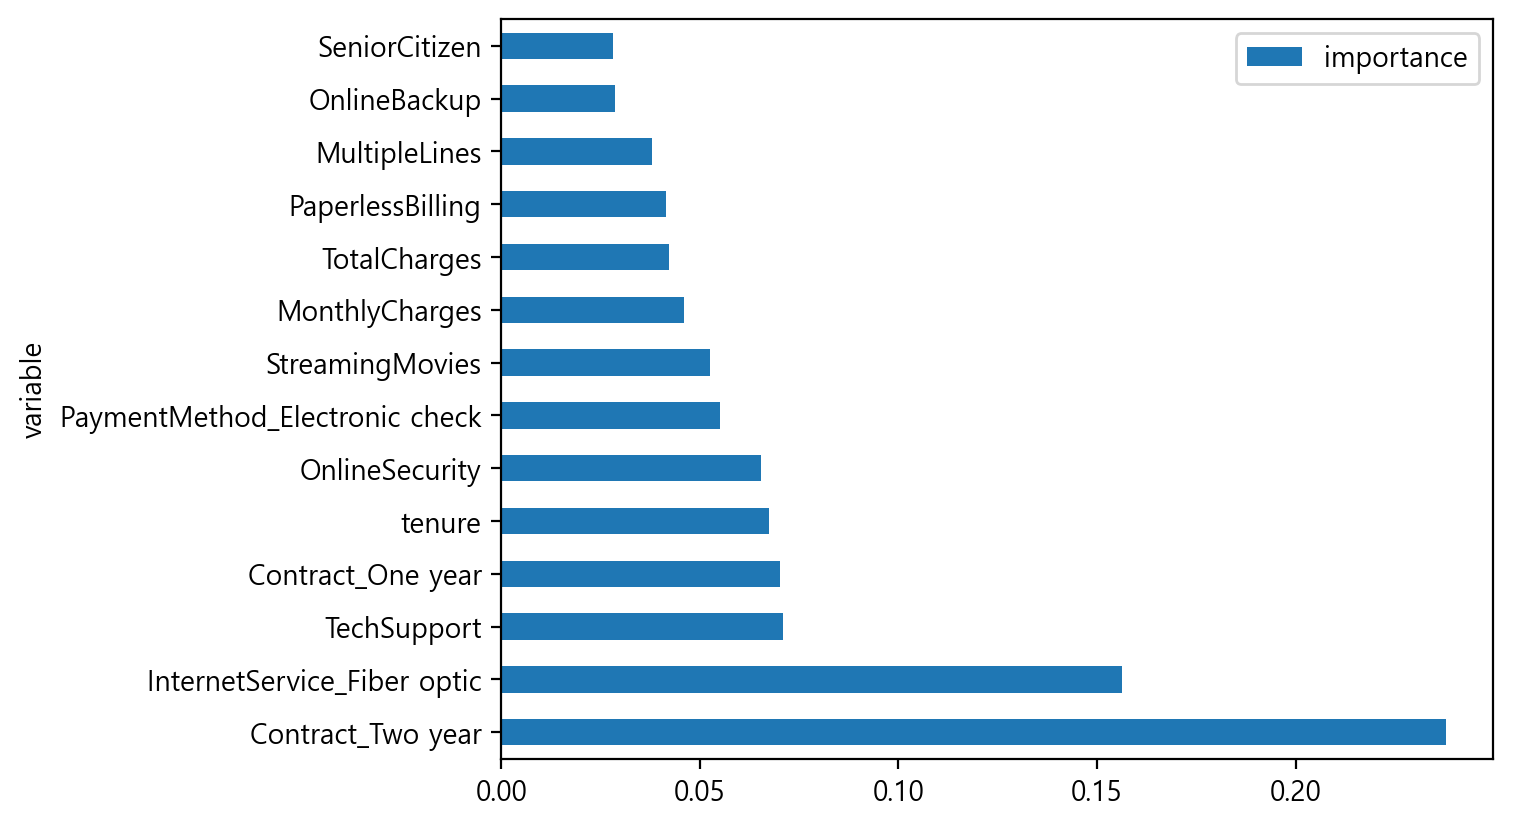

In [679]:
xgb_gini_importance.plot.barh(x='variable', y='importance')

#### PDP (Partial Dependence Plots)

In [32]:
# Calibrate XGBoost model
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve

xgb_best_params['n_estimators']=best_xgb.best_iteration
xgb_calibrated =  xgb.XGBClassifier(n_jobs=-1, random_state=802, scale_pos_weight=pos_weight, **xgb_best_params)
xgb_calibrated = CalibratedClassifierCV(estimator=xgb_calibrated, method='isotonic', cv=5, n_jobs=-1)
xgb_calibrated.fit(train_X_final_stdX, train_y)

CalibratedClassifierCV(cv=5,
                       estimator=XGBClassifier(base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=0.6,
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eval_metric=None,
                                               feature_types=None, gamma=None,
                                               gpu_id=None, grow_policy=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                                               learning_rate=0.001,
                                               max_bin=None,
                                               max_cat_threshold=None,
                                               max_cat_to_onehot=None,
                                               max_delta_step=None, max_depth=3,
                                               max_leaves=None,
                                               min_child_weight=None,
                                               missing=nan,
                                               monotone_constraints=None,
                                               n_estimators=3163, n_jobs=-1,
                                               num_parallel_tree=None,
                                               predictor=None, random_state=802, ...),
                       method='isotonic', n_jobs=-1)

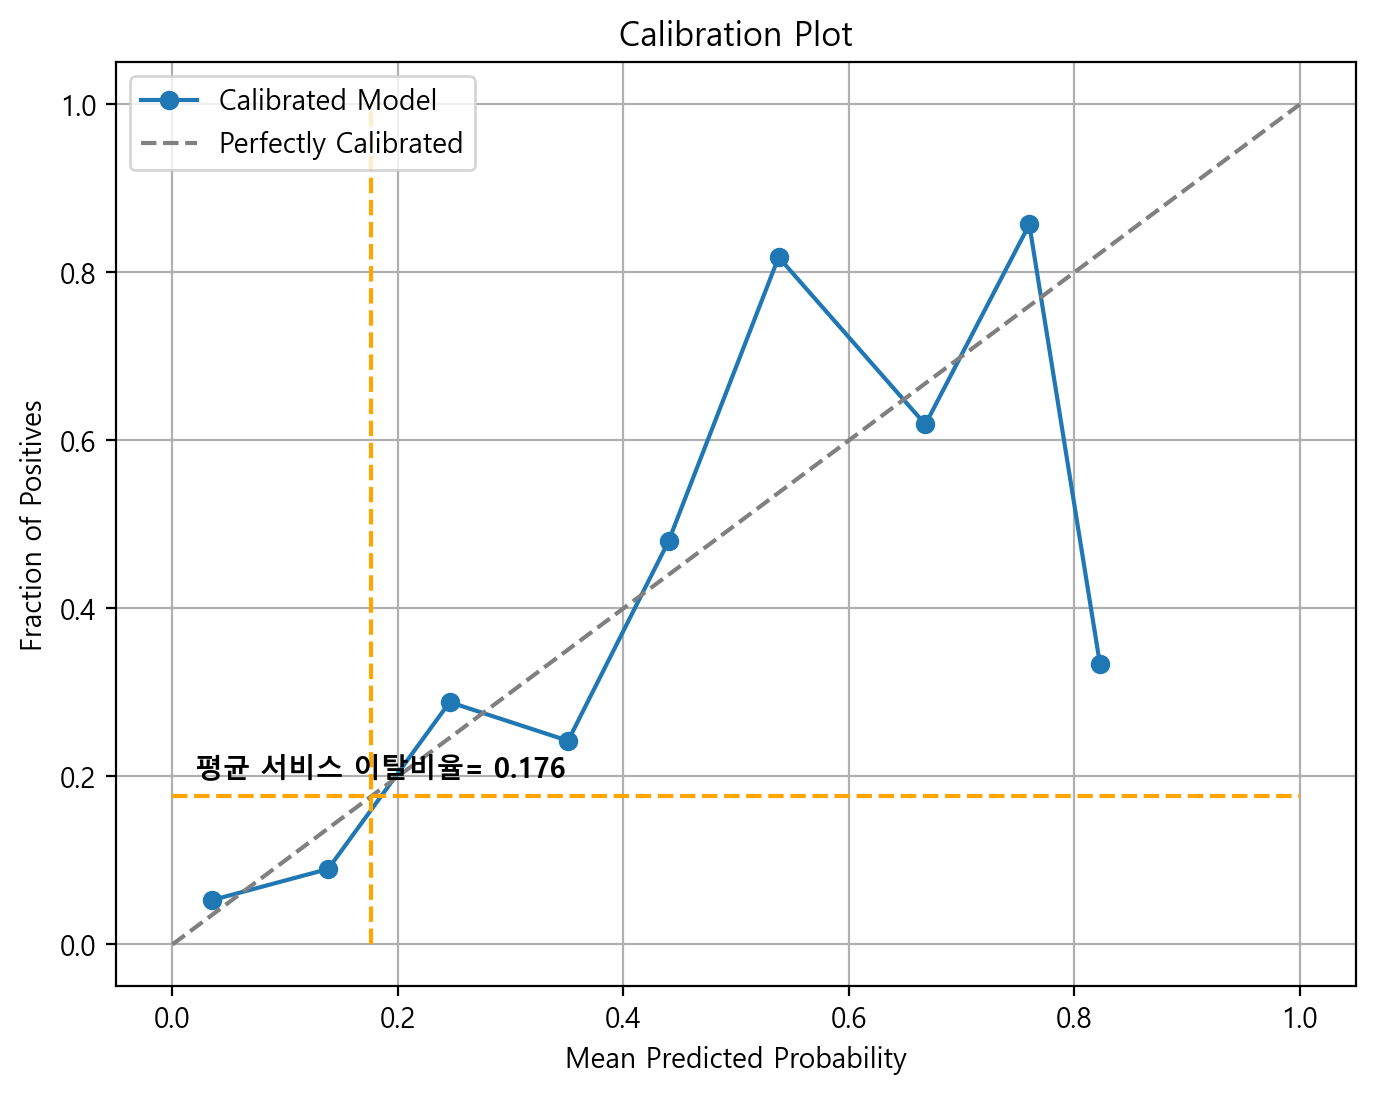

In [49]:
# Predict probabilities using your calibrated model
calibrated_probs = xgb_calibrated.predict_proba(test_X_final_stdX)[:, 1]  # Adjust based on your data

# Calculate true probabilities and predicted probabilities
true_probs, predicted_probs = calibration_curve(test_y, calibrated_probs, n_bins=10)

# Create a calibration plot
_ =plt.figure(figsize=(8, 6))
_ =plt.plot(predicted_probs, true_probs, marker='o', label='Calibrated Model')
_ =plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
_ =plt.xlabel('Mean Predicted Probability')
_ =plt.ylabel('Fraction of Positives')
_ =plt.hlines(y=test_y.mean(), xmin=0, xmax=1, color='orange', linestyle='dashed')
_ =plt.vlines(x=test_y.mean(), ymin=0, ymax=1, color='orange', linestyle='dashed')
_ =plt.text(x=0.02, y=0.2, s=f'평균 서비스 이탈비율= {round(test_y.mean(), 3)}', fontdict=dict(weight='bold'))
_ =plt.title('Calibration Plot')
_ =plt.legend()
_ =plt.grid()
_ =plt.show()

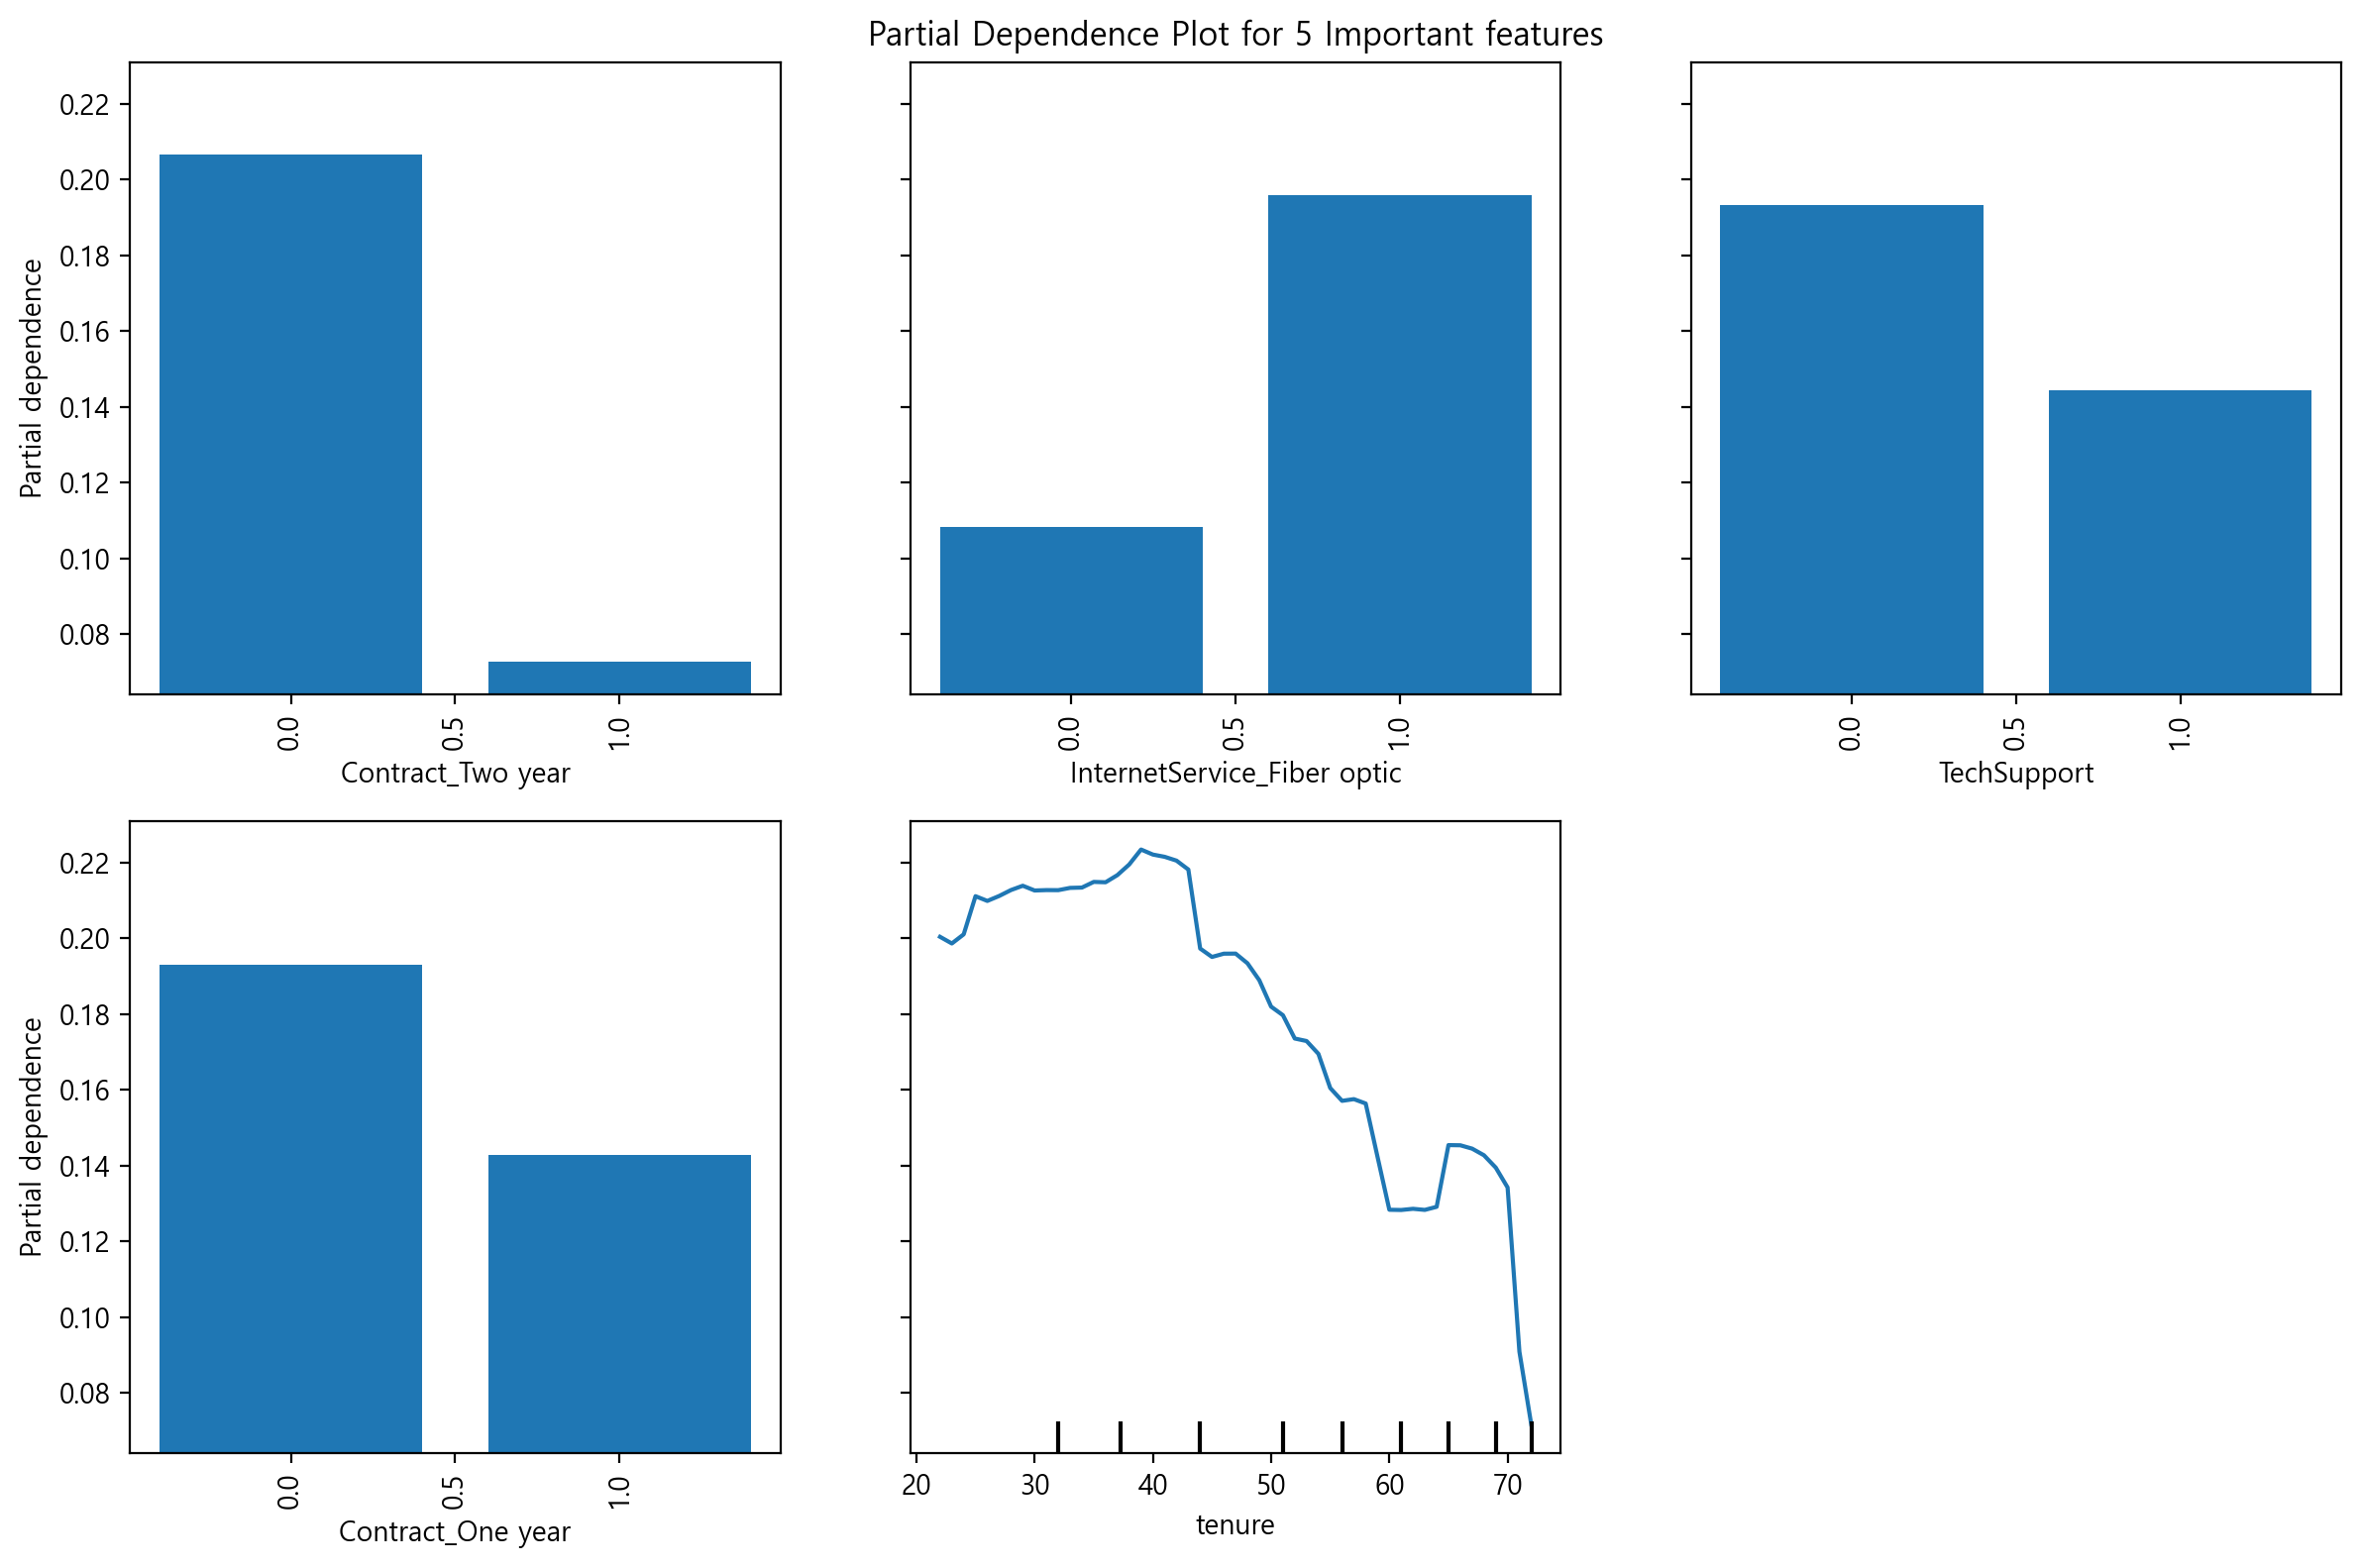

In [884]:
from sklearn.inspection import PartialDependenceDisplay
important_feature_index = train_X_final_stdX.columns.get_indexer(xgb_gini_importance.loc[0:4, 'variable'])

fig, ax = plt.subplots(figsize=(12, 8))
_ = PartialDependenceDisplay.from_estimator(estimator=xgb_calibrated, X=train_X_final_stdX, features=important_feature_index,
                                       categorical_features=important_feature_index[:-1],
                                        n_cols=3, ax=ax)
_ = ax.set_title('Partial Dependence Plot for 5 Important features')
_ = plt.tight_layout()